# Clustering using the ROSTRUM label

This notebook is based on `20220901_clustering-rostrum-only.ipynb` in the original repo.

Here the tracks are clustered using the ROSTRUM label only based on the following findings:
- Using both the DTAG and ROSTRUM labels, 2 TC trials were grouped with the CT trials
- Using only the DTAG labels, many TC and CT trials are mixed together, even though the majority was well separated
- Using only the ROSTRUM labels, the TC and CT trials are well separated, and the cluster membership is not drastically different from those from using both ROSTRUM and DTAG labels

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

In [2]:
from pp_utils.core import generate_data_path_dict
from pp_utils.file_handling import df_main_loader
from pp_utils.track_features import get_feature_array

## Set paths and load main info df

In [3]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Output path

In [4]:
output_path = data_path["main"] / "data_summary"
if not output_path.exists():
    output_path.mkdir()

### Load main dataframe

In [5]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load track portion

In [6]:
# track portions used for clustering
with open(output_path / "track_portion_all.pickle", "rb") as filein:
    df_track_portion_all = pickle.load(filein)

## Trials with valid track portions

Assemble a dataframe consisting of only trials with valid track portions.

In [7]:
df_sel = []
for trial_idx, df in enumerate(df_track_portion_all):
    if df is not None:
        df_sel.append(df_main.loc[trial_idx])

In [8]:
df_sel = pd.concat(df_sel, axis=1).T

In [9]:
# Visual sanity check
df_sel

,DATE,SESSION,PERSONNEL,TRIAL,LEFT,RIGHT,ANGLE,SPHEROID,ASPECT_RATIO,SEQUENCE,...,CHIRP_trial_has_chirp,CHIRP_trial_has_clutter_object,CHIRP_trial_clicks_synced,LED_trial_has_LED,LED_trial_has_clutter_object,LED_trial_clicks_synced,trials_sync_both_chirp_and_LED,trials_sync_at_least_chirp_or_LED,fname_prefix,TARGET_ANGLE
2,20190625,1,"WJ, ML",1,T,C,1,L,2.9,1,...,True,True,True,False,False,False,False,True,20190625_s1_t1,TC1
3,20190625,1,"WJ, ML",2,C,T,1,L,2.9,1,...,True,True,True,False,False,False,False,True,20190625_s1_t2,CT1
4,20190625,1,"WJ, ML",3,T,C,1,L,2.9,1,...,True,True,True,False,False,False,False,True,20190625_s1_t3,TC1
5,20190625,1,"WJ, ML",4,C,T,1,L,2.9,1,...,True,True,True,False,False,False,False,True,20190625_s1_t4,CT1
6,20190625,1,"WJ, ML",5,T,C,1,L,2.9,1,...,True,True,True,False,False,False,False,True,20190625_s1_t5,TC1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,20190704,3,ML,6,T,C,4,M,1.3,24,...,True,True,True,True,True,True,True,True,20190704_s3_t6,TC4
241,20190704,3,ML,7,C,T,3,M,1.3,24,...,True,True,True,True,True,True,True,True,20190704_s3_t7,CT3
242,20190704,3,ML,8,T,C,1,M,1.3,24,...,True,True,True,True,True,True,True,True,20190704_s3_t8,TC1
243,20190704,3,ML,9,C,T,3,M,1.3,24,...,True,True,True,True,True,True,True,True,20190704_s3_t9,CT3


In [10]:
# Only select the AR=1.3 trials
df_sel = df_sel[df_sel["SPHEROID"]=="M"].copy()

### Check CHOICE in selected trials

In [11]:
df_sel["TARGET_ANGLE"].value_counts()

CT4    13
TC1    12
TC4    11
CT3    10
TC3    10
TC2     9
CT2     8
CT1     7
Name: TARGET_ANGLE, dtype: int64

## Assemble dict of track portion indexed by trial index

In [12]:
dict_df_track_sel = dict()
for trial_idx in df_sel.index:
    trial_name = df_sel.loc[trial_idx]["fname_prefix"]
    dict_df_track_sel[trial_name] = df_track_portion_all[trial_idx]

In [13]:
len(dict_df_track_sel)

80

## Assemble and clean feature array

In [14]:
feature_array, feature_len = get_feature_array(
    list_df_track=list(dict_df_track_sel.values()),
    feature_name=["ROSTRUM_X", "ROSTRUM_Y"],
    normalize_time=True,
)

In [15]:
feature_array.shape

(80, 101, 2)

In [16]:
feature_array_reshaped = (
    np.moveaxis(feature_array, [0, 1, 2], [2, 1, 0])
    .reshape((-1, feature_array.shape[0])).T
)

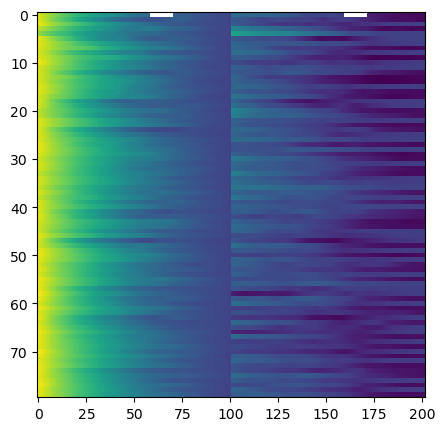

In [17]:
plt.figure(figsize=(5, 5))
plt.imshow(feature_array_reshaped, aspect="auto", interpolation="none")
plt.show()

### Remove trial with NaN entries

We can see that there are some NaN points in the feature matrix (in ROSTRUM marker and ICI). Let's find out which trials these are.

In [18]:
# Find index of the trial in the feature_array that has NaN entries
idx_trial_nan = np.argwhere(np.sum(np.isnan(feature_array_reshaped), axis=1) != 0)[0][0]
idx_trial_nan

0

In [19]:
# Find out trial to remove
trial_to_remove = list(dict_df_track_sel.keys())[idx_trial_nan]
trial_to_remove

'20190627_s2_t8'

In [20]:
# Remove NaN trial
_ = dict_df_track_sel.pop(trial_to_remove)

feature_array = np.delete(feature_array, idx_trial_nan, axis=0)
feature_array_reshaped = np.delete(feature_array_reshaped, idx_trial_nan, axis=0)

df_sel.drop(
    index=df_sel[
        df_sel["fname_prefix"] == trial_to_remove
    ].index,
    axis=1, inplace=True
)

In [21]:
# Sanity check
assert len(dict_df_track_sel) == 79
assert len(df_sel) == 79
assert feature_array.shape[0] == 79
assert feature_array_reshaped.shape[0] == 79

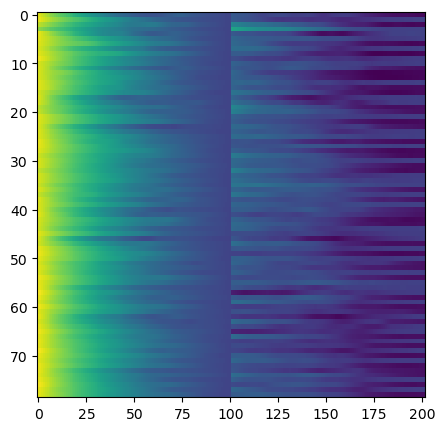

In [22]:
plt.figure(figsize=(5, 5))
plt.imshow(
    feature_array_reshaped[:,:404],  # reshape to plot 2 features together
    aspect="auto", interpolation="none"
)
plt.show()

## Hierarchical clustering

In [23]:
import seaborn as sns

### Create condition colormap

In [24]:
cmap_cluster = plt.cm.get_cmap('bwr')
boundaries = np.arange(9)
norm = plt.cm.colors.BoundaryNorm(boundaries, cmap_cluster.N, clip=True)

/var/folders/1m/8nxc8r_900778tkhqfgh0nqh0000gn/T/ipykernel_22211/8497452.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_cluster = plt.cm.get_cmap('bwr')


In [25]:
TARGET_ANGLE_SEQ = np.array(["TC1", "TC2", "TC3", "TC4", "CT1", "CT2", "CT3", "CT4"])

In [26]:
color_vals8 = cmap_cluster((boundaries[:-1]+0.5)/boundaries.max())
color_vals8

array([[0.1254902 , 0.1254902 , 1.        , 1.        ],
       [0.37647059, 0.37647059, 1.        , 1.        ],
       [0.62745098, 0.62745098, 1.        , 1.        ],
       [0.87843137, 0.87843137, 1.        , 1.        ],
       [1.        , 0.87058824, 0.87058824, 1.        ],
       [1.        , 0.61960784, 0.61960784, 1.        ],
       [1.        , 0.36862745, 0.36862745, 1.        ],
       [1.        , 0.11764706, 0.11764706, 1.        ]])

Plot target-angle color code:

In [27]:
def plot_color_code(color_vals):
    plt.imshow(np.expand_dims(color_vals, axis=0))
    plt.xticks(np.arange(8), TARGET_ANGLE_SEQ, fontsize=12)
    plt.show()

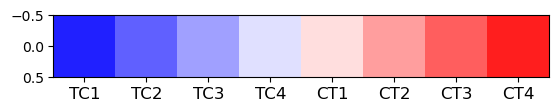

In [28]:
plot_color_code(color_vals8)

### Clustering plotting functions

In [29]:
def get_yticklabel(df_selected, cgrid):
    df_yticklabel = df_selected.iloc[cgrid.dendrogram_row.reordered_ind].reset_index()
    df_yticklabel["ticklabels"] = df_yticklabel.apply(
        lambda x: (
            str(x.name) + "__" 
            + str(x["index"]) + "__" 
            + x["fname_prefix"] + "__" 
            + x["TARGET_ANGLE"]
        ), axis=1
    )
    return df_yticklabel["ticklabels"]

In [30]:
def get_cluster_index_from_leaves(dendro):
    groups = []
    for k,v in groupby(dendro["leaves_color_list"]):
        groups.append(list(v))

    groups_len = [len(gg) for gg in groups]
    groups_len

    groups_len = [None] + np.cumsum(groups_len).tolist()
    groups_len

    # Get a list for plotting
    gg_list = []
    for gg0, gg1 in zip(groups_len[:-1], groups_len[1:]):
        gg_list.append([gg0, gg1])
        
    return gg_list

In [31]:
def plot_group_tracks(cgrid, idx_list, label="DTAG"):
    fig, ax = plt.subplots(1, len(idx_list), figsize=(16,3), sharey=True)
    for seq, idx_plot in enumerate(idx_list):
        if idx_plot[0] is not None and idx_plot[1] is not None:
            idx_plot = df_sel.iloc[
                cgrid.dendrogram_row.reordered_ind[idx_plot[0]:idx_plot[1]]
            ]["fname_prefix"]
        elif idx_plot[0] is None:
            idx_plot = df_sel.iloc[
                cgrid.dendrogram_row.reordered_ind[:idx_plot[1]]
            ]["fname_prefix"]
        elif idx_plot[1] is None:
            idx_plot = df_sel.iloc[
                cgrid.dendrogram_row.reordered_ind[idx_plot[0]:]
            ]["fname_prefix"]
        for idx in idx_plot:
            ax[seq].plot(
                dict_df_track_sel[idx][label+"_X"],
                dict_df_track_sel[idx][label+"_Y"],
                alpha=0.3, lw=2, color="C0"#, 'C'+str(seq), 
            )
            
    for axx in ax:
        axx.set_ylim(2, -2)
        
    plt.show()

In [32]:
def plot_overlay_tracks(ax, cgrid, idx_list):
    for seq, idx_plot in enumerate(idx_list):
        if idx_plot[0] is not None and idx_plot[1] is not None:
            idx_plot = df_sel.iloc[cgrid.dendrogram_row.reordered_ind[idx_plot[0]:idx_plot[1]]]["fname_prefix"]
        elif idx_plot[0] is None:
            idx_plot = df_sel.iloc[cgrid.dendrogram_row.reordered_ind[:idx_plot[1]]]["fname_prefix"]
        elif idx_plot[1] is None:
            idx_plot = df_sel.iloc[cgrid.dendrogram_row.reordered_ind[idx_plot[0]:]]["fname_prefix"]
        for idx in idx_plot:
            ax.plot(
                dict_df_track_sel[idx]["DTAG_X"],
                dict_df_track_sel[idx]["DTAG_Y"],
                alpha=0.25, lw=1.5, color='C'+str(seq), 
            )

In [33]:
def get_contingency_mtx_from_list(cgrid, idx_list):
    df_tca = pd.concat(
            [pd.DataFrame(index=TARGET_ANGLE_SEQ), df_sel["TARGET_ANGLE"].value_counts()],
            axis=1,
        )
    for seq, idx in enumerate(idx_list):
        if idx[0] is not None and idx[1] is not None:
            df_tmp = (
                df_sel.iloc[cgrid.dendrogram_row.reordered_ind]
                .reset_index()[idx[0]:idx[1]]["TARGET_ANGLE"]
            )
        elif idx[0] is None:
            df_tmp = (
                df_sel.iloc[cgrid.dendrogram_row.reordered_ind]
                .reset_index()[:idx[1]]["TARGET_ANGLE"]
            )
        elif idx[1] is None:
            df_tmp = (
                df_sel.iloc[cgrid.dendrogram_row.reordered_ind]
                .reset_index()[idx[0]:]["TARGET_ANGLE"]
            )
        # Assemble contingency matrix
        df_tca = pd.concat(
            [
                df_tca,
                (
                    df_tmp
                    .value_counts().to_frame()
                    .rename(columns={"TARGET_ANGLE": "cluster_" + str(seq)})
                ),
            ],
            axis=1,
        )    
    return df_tca.drop("TARGET_ANGLE", axis=1)

In [34]:
def plot_contingency_mtx(df_cont, idx_list, title_str):
    im = plt.imshow(df_cont, aspect='auto', cmap="Reds")
    plt.yticks(
        np.arange(TARGET_ANGLE_SEQ.size),
        TARGET_ANGLE_SEQ, fontsize=14
    )
    plt.axis('equal')
    plt.xticks(np.arange(len(idx_list)), fontsize=14)
    plt.colorbar()
    plt.title(title_str, fontsize=14)
    plt.show()

In [35]:
def get_fnameprefix_from_clusters(cgrid, idx_list):
    
    fname_prefix_all = []
    for seq, idx_plot in enumerate(idx_list):
        if idx_plot[0] is not None and idx_plot[1] is not None:
            fname_prefix = df_sel.iloc[
                cgrid.dendrogram_row.reordered_ind[idx_plot[0]:idx_plot[1]]
            ]["fname_prefix"]
        elif idx_plot[0] is None:
            fname_prefix = df_sel.iloc[
                cgrid.dendrogram_row.reordered_ind[:idx_plot[1]]
            ]["fname_prefix"]
        elif idx_plot[1] is None:
            fname_prefix = df_sel.iloc[
                cgrid.dendrogram_row.reordered_ind[idx_plot[0]:]
            ]["fname_prefix"]
        fname_prefix_all.append(fname_prefix.values)
    return fname_prefix_all

### Clustering: ROSTRUM

In [36]:
tca8 = dict(zip(TARGET_ANGLE_SEQ, color_vals8))
tca8 = df_sel["TARGET_ANGLE"].map(tca8)

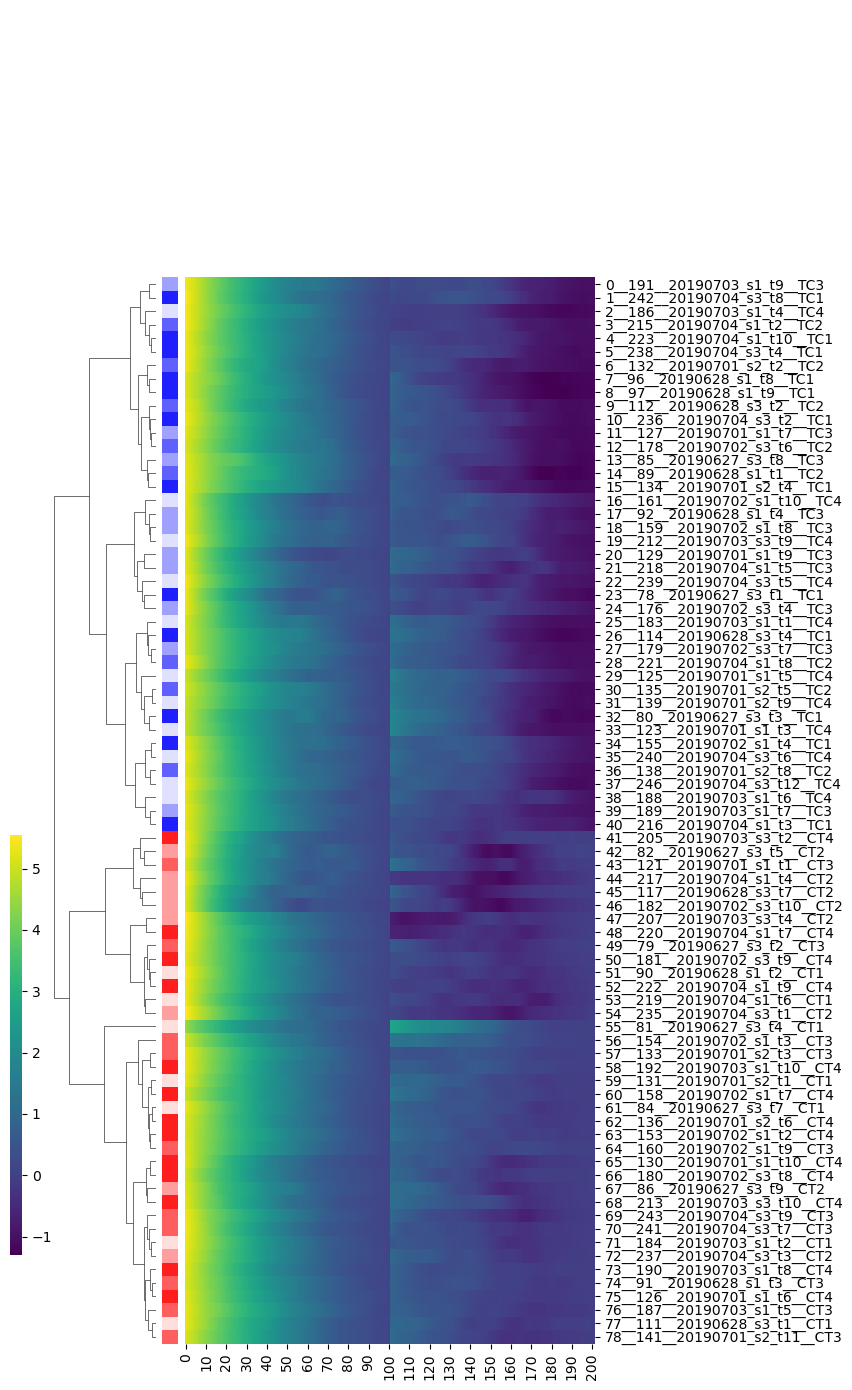

In [37]:
figsize = (6, 14)

g = sns.clustermap(
    feature_array_reshaped,
    method="ward",
    metric="euclidean",
    row_colors=tca8.to_numpy(),
    col_cluster=False,
    cmap="viridis",
    figsize=figsize,
    cbar_pos=[-.04, .1, .02, .3],
)

g.ax_heatmap.set_yticks(np.arange(feature_array_reshaped.shape[0])+0.5)
g.ax_heatmap.set_yticklabels(get_yticklabel(df_sel, g))
g.ax_heatmap.tick_params(axis='y', labelrotation=0)
plt.show()

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage

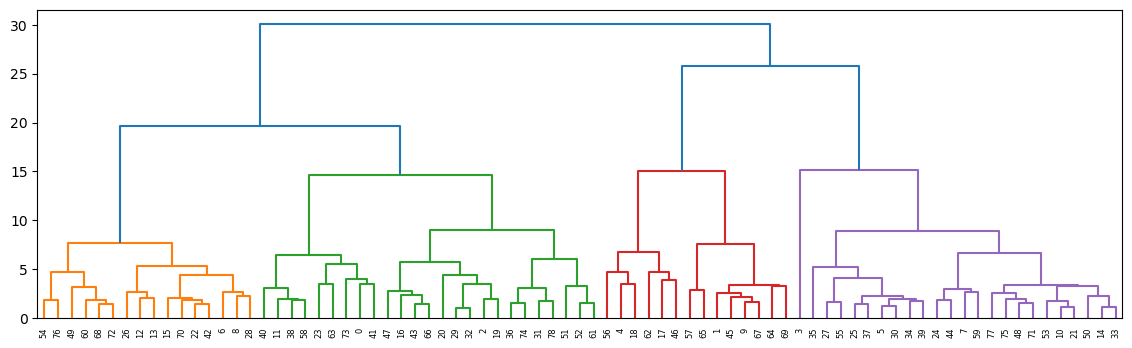

In [39]:
Z = linkage(feature_array_reshaped, 'ward')

fig = plt.figure(figsize=(14, 4))
dn = dendrogram(Z, color_threshold=18)

### Use the above cut on the dendrogram to plot clustered tracks

In [40]:
from itertools import groupby

In [41]:
gg_list = get_cluster_index_from_leaves(dn)

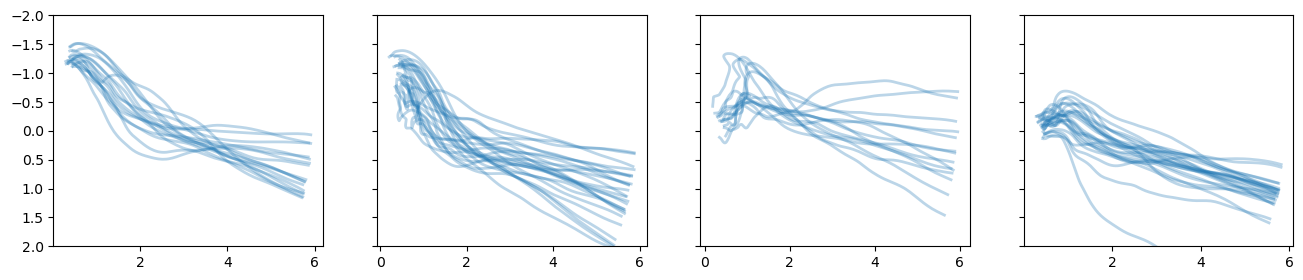

In [42]:
plot_group_tracks(cgrid=g, idx_list=gg_list, label="DTAG")

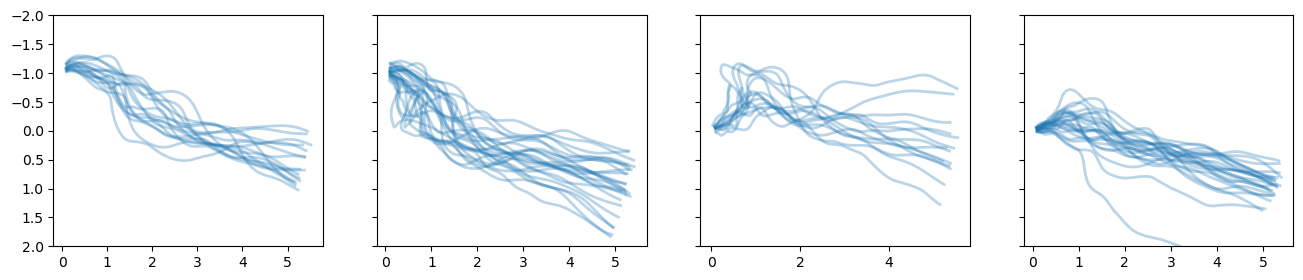

In [43]:
plot_group_tracks(cgrid=g, idx_list=gg_list, label="ROSTRUM")

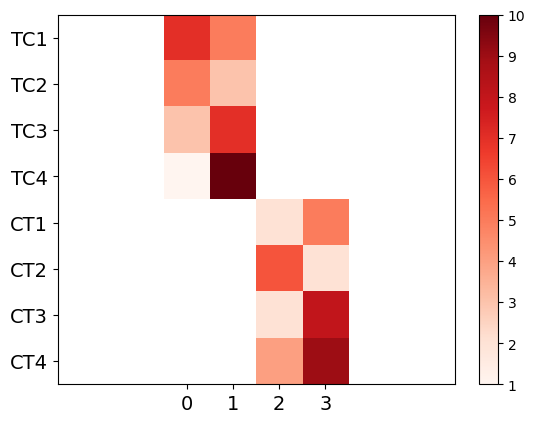

In [44]:
plot_contingency_mtx(
    get_contingency_mtx_from_list(cgrid=g, idx_list=gg_list), idx_list=gg_list, title_str=None
)

### Plot track overlay for TC and CT separately

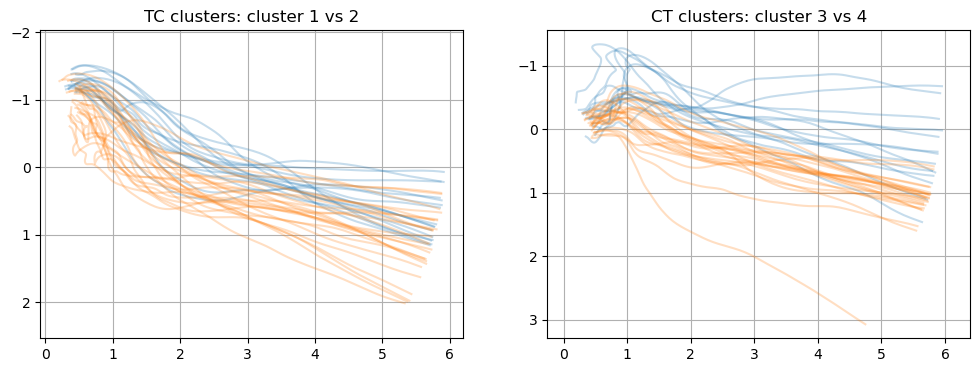

In [45]:
fig, ax=plt.subplots(1, 2, figsize=(12, 4))

# Cluster 1 and 2: TC trials
plot_overlay_tracks(ax=ax[0], cgrid=g, idx_list=gg_list[:2])
ax[0].set_title("TC clusters: cluster 1 vs 2")

# Cluster 3 and 4: CT trials
plot_overlay_tracks(ax=ax[1], cgrid=g, idx_list=gg_list[2:])
ax[1].set_title("CT clusters: cluster 3 vs 4")

for axx in ax:
    axx.set_ylim(2, -2)
    axx.axis("equal")
    axx.grid()

### Save clustering results

In [46]:
fname_prefix_list = get_fnameprefix_from_clusters(cgrid=g, idx_list=gg_list)

In [47]:
with open(
    output_path / f"clustering_{len(fname_prefix_list)}_rostrum_only.pickle", "wb"
) as fileout:
    pickle.dump(fname_prefix_list, fileout)

## Make another cut on dendrogam

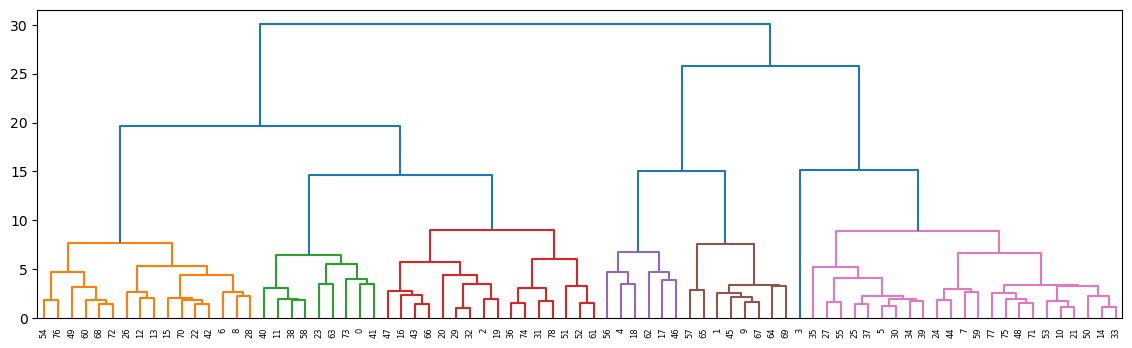

In [48]:
fig = plt.figure(figsize=(14, 4))
dn = dendrogram(Z, color_threshold=13)

In [49]:
gg_list = get_cluster_index_from_leaves(dn)

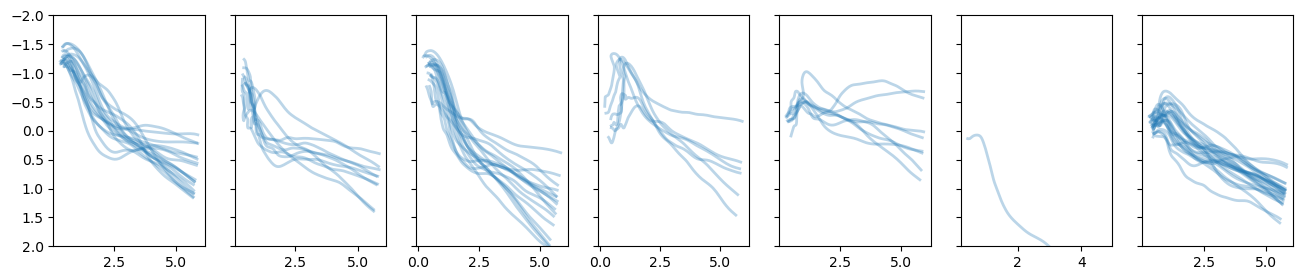

In [50]:
plot_group_tracks(cgrid=g, idx_list=gg_list, label="DTAG")

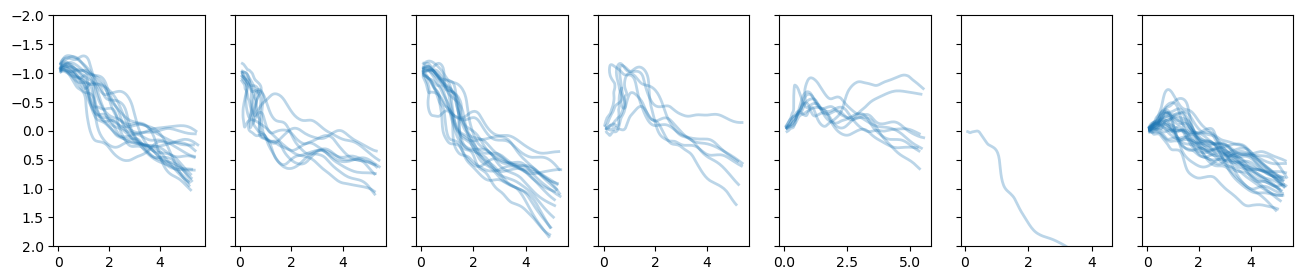

In [51]:
plot_group_tracks(cgrid=g, idx_list=gg_list, label="ROSTRUM")

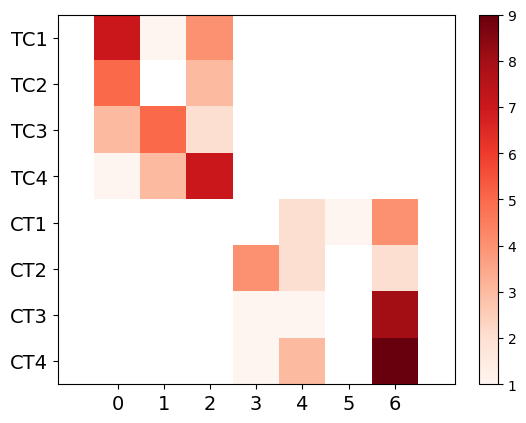

In [52]:
plot_contingency_mtx(
    get_contingency_mtx_from_list(cgrid=g, idx_list=gg_list), idx_list=gg_list, title_str=None
)

### Save clustering results

In [53]:
fname_prefix_list = get_fnameprefix_from_clusters(cgrid=g, idx_list=gg_list)

In [54]:
with open(
    output_path / f"clustering_{len(fname_prefix_list)}_rostrum_only.pickle", "wb"
) as fileout:
    pickle.dump(fname_prefix_list, fileout)